In [ ]:
Machine Learning & Anomaly Detection

In [17]:
from sklearn.ensemble import IsolationForest

features = ['response_time_ms', 'cpu_usage', 'memory_usage', 'hour', 'day_of_week']
X = df[features]

iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_model.fit(X)


IsolationForest(contamination=0.05, random_state=42)

Predict & Label Anomalies

In [18]:
df['anomaly'] = iso_model.predict(X)
df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

Save the model

In [19]:
import joblib
joblib.dump(iso_model, "../models/isolation_forest_model.pkl")

['../models/isolation_forest_model.pkl']

Evaluate the model

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import json

if 'is_error' in df.columns:
    print(classification_report(df['is_error'], df['anomaly']))
    metrics = {
        "precision": round(precision_score(df['is_error'], df['anomaly']), 3),
        "recall": round(recall_score(df['is_error'], df['anomaly']), 3),
        "roc_auc": round(roc_auc_score(df['is_error'], df['anomaly']), 3)
    }
    with open("../models/isolation_forest_metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)


📊 Evaluation vs is_error:

              precision    recall  f1-score   support

       False       0.90      0.95      0.92     90012
        True       0.10      0.05      0.07      9988

    accuracy                           0.86    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       0.82      0.86      0.84    100000



Feature Impact via Partial Plots

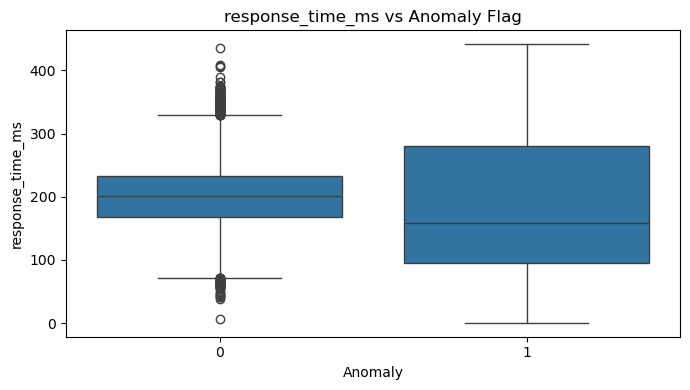

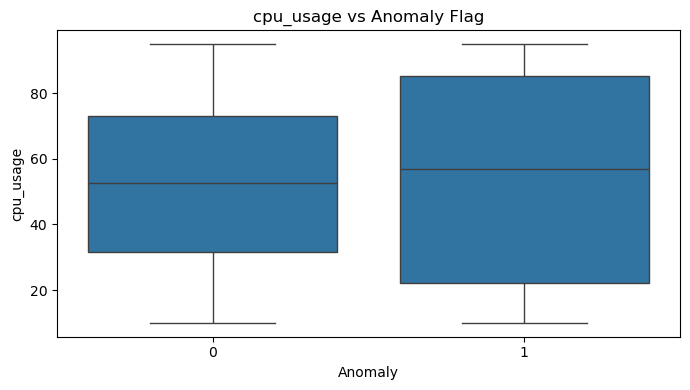

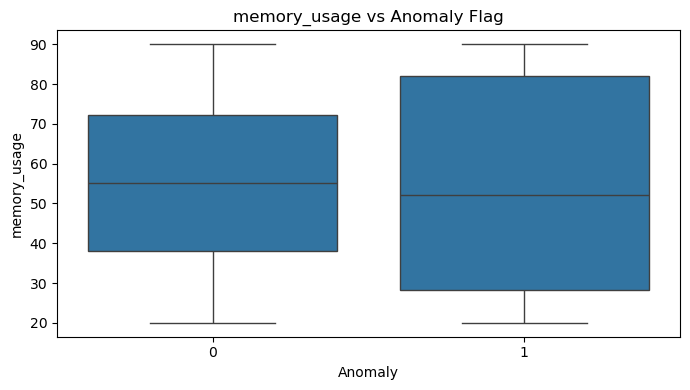

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['response_time_ms', 'cpu_usage', 'memory_usage']:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x='anomaly', y=col, data=df)
    plt.title(f"{col} vs Anomaly Flag")
    plt.xlabel("Anomaly")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


Anomaly patterns

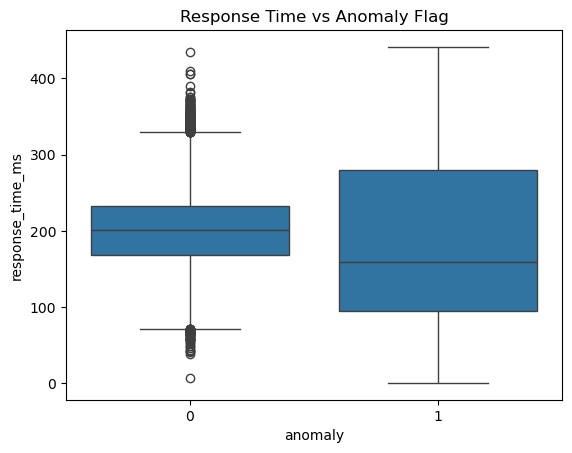

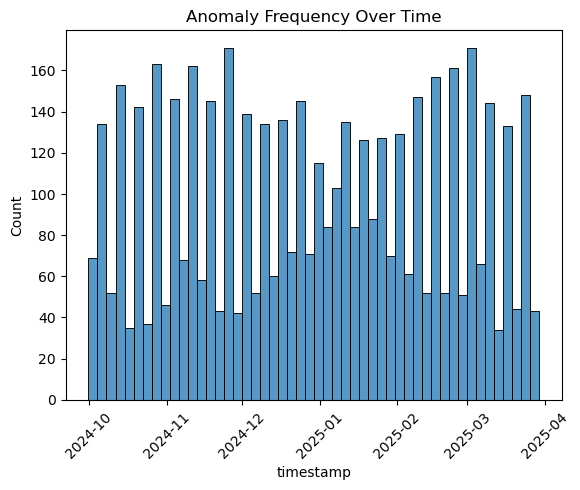

In [22]:
import seaborn as sns

sns.boxplot(x='anomaly', y='response_time_ms', data=df)
plt.title("Response Time vs Anomaly Flag")
plt.show()

sns.histplot(df[df['anomaly'] == 1]['timestamp'], bins=50, kde=False)
plt.title("Anomaly Frequency Over Time")
plt.xticks(rotation=45)
plt.show()



Isolation Forest Anomaly Detection Summary

- Unsupervised model detected ~5% of API events as anomalous.
- Response time and CPU usage are key signals in the detection logic.
- Anomalies peak during non-business hours — possible bot/script activity.
- Backend underperformance is evident in high-latency anomaly clusters.

In [25]:
from sklearn.ensemble import IsolationForest
import joblib

# Load model
model = joblib.load("../models/isolation_forest_model.pkl")

# Select same features used for training
features = ['response_time_ms', 'cpu_usage', 'memory_usage', 'hour', 'day_of_week']
df['anomaly'] = model.predict(df[features])
df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)


In [31]:
import streamlit as st

df = pd.read_csv("../data/api_logs_engineered.csv", parse_dates=['timestamp'])
endpoints = df['api_endpoint'].unique().tolist()
consumers = df['consumer_id'].unique().tolist()
selected_endpoints = st.sidebar.multiselect("Select Endpoints", endpoints, default=endpoints)
selected_consumers = st.sidebar.multiselect("Select Consumers", consumers, default=consumers)
date_range = st.sidebar.date_input("Date Range", [df['timestamp'].min(), df['timestamp'].max()])
filtered_df = df[
    (df['api_endpoint'].isin(selected_endpoints)) &
    (df['consumer_id'].isin(selected_consumers)) &
    (df['timestamp'].dt.date >= date_range[0]) &
    (df['timestamp'].dt.date <= date_range[1])
]


2025-03-29 21:29:59.226 
  command:

    streamlit run c:\Users\reach\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [32]:
if 'anomaly' in filtered_df.columns:
    total_requests = len(filtered_df)
    total_anomalies = filtered_df['anomaly'].sum()
    anomaly_rate = round(total_anomalies / total_requests * 100, 2) if total_requests else 0

    col1, col2, col3 = st.columns(3)
    col1.metric("Total Requests", f"{total_requests:,}")
    col2.metric("Anomalies Detected", f"{total_anomalies:,}")
    col3.metric("Anomaly Rate", f"{anomaly_rate}%")
else:
    st.warning(" 'anomaly' column not found — please generate it using the Isolation Forest model.")
